# How to Do Deep Learning on Graphs with Graph Convolutional Networks
## Part 2: Semi-Supervised Learning with Spectral Graph Convolutions
This notebook accompanies my Medium article with the above title for readers to try out and explore graph convolutional networks for themselves. You can find the article [here](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0). To run the notebook, install the packages specified in the accompanying ```requirements.txt``` file.

#  Load Karate Club

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 50)
mr_dataset = pd.read_csv(r'data\mr.clean.txt', sep='\n', header=None, encoding='ascii')
print(mr_dataset.head())

                                                   0
0  'moore is like a progressive bull in a china s...
1                                   idiotic and ugly
2  even if the naipaul original remains the real ...
3  the movie is amateurish , but it 's a minor treat
4  some people march to the beat of a different d...


In [2]:
import pandas as pd
import numpy as np
import sys
from scipy.spatial.distance import cdist

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)
pd.set_option('display.max_colwidth', 50)

n_all = 30
n_train = round((2/3.0) * n_all)
n_train_positive = round(n_train/2.0)
n_train_negative = n_train - n_train_positive
n_test = n_all - n_train
n_test_positive = round(n_test/2.0)
n_test_negative = n_test - n_test_positive

doc_vec = pd.read_csv(r'data\mr_doc_vectors.txt', header=None, delimiter=' ')
train_positive = pd.DataFrame.reset_index(doc_vec.iloc[:3554, 1:].sample(n=n_train_positive, random_state=0), drop=True)
train_negative = pd.DataFrame.reset_index(doc_vec.iloc[3554:7108, 1:].sample(n=n_train_negative, random_state=0), drop=True)
test_positive = pd.DataFrame.reset_index(doc_vec.iloc[7108:8885, 1:].sample(n=n_test_positive, random_state=0), drop=True)
test_negative = pd.DataFrame.reset_index(doc_vec.iloc[8885:, 1:].sample(n=n_test_negative, random_state=0), drop=True)
all_data = pd.DataFrame.reset_index(pd.concat([train_positive, train_negative, test_positive, test_negative]), drop=True)

# X_train = np.concatenate((train_positive.index.to_numpy(), train_negative.index.to_numpy()))
# X_test = np.concatenate((test_positive.index.to_numpy(), test_negative.index.to_numpy()))
X_train = np.array(range(n_train))
X_test = np.array(range(n_train, n_all))

doc_labels = pd.read_csv(r'data\label.txt', header=None, delimiter='\n')
y_train_p = doc_labels.iloc[:3554].sample(n=n_train_positive, random_state=0)
y_train_n = doc_labels.iloc[3554:7108].sample(n=n_train_negative, random_state=0)
y_test_p = doc_labels.iloc[7108:8885].sample(n=n_test_positive, random_state=0)
y_test_n = doc_labels.iloc[8885:].sample(n=n_test_negative, random_state=0)

y_train = np.squeeze(pd.concat([y_train_p, y_train_n]).to_numpy())
y_test = np.squeeze(pd.concat([y_test_p, y_test_n]).to_numpy())

A = np.zeros((n_all, n_all), dtype = int)
# distance smaller than this threshold between two document embeddings means they are neighbours
doc_dist_tau = 0.64
i = 0
while i < n_all:
#     print('i:', i)
    if i == n_all - 1:
#         print('Last row')
        if np.sum(A[i]) == 0:
#             print('Last row is zero')
            A = np.zeros((n_all, n_all), dtype=int)
            i = 0
            doc_dist_tau *= 1.5
        else:
            i = n_all
    else:
        for j in range(i+1, n_all):
#             print('j:', j)
            dist = np.linalg.norm(all_data.iloc[i] - all_data.iloc[j])
#             print(dist)
            if dist < doc_dist_tau:
#                 print('row', i, 'is not zero')
                A[i,j] = A[j,i] = 1
        if np.sum(A[i]) == 0:
            A = np.zeros((n_all, n_all), dtype=int)
            i = 0
            doc_dist_tau *= 1.5
#             print('tau:', doc_dist_tau)
        else:
            i += 1
print(doc_dist_tau)

0.64


In [3]:
import mxnet.ndarray as nd
A_df = pd.DataFrame(data=A, index=all_data.index, columns=all_data.index)
A = nd.array(A)

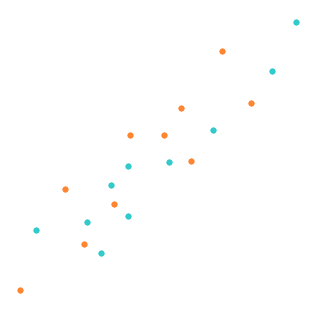

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10,10), dpi=40)
G = nx.from_pandas_adjacency(A_df)
pos = nx.spring_layout(G)  # positions for all nodes

group1 = list(range(n_train_positive))
group2 = list(range(n_train_positive, n_train))
group3 = list(range(n_train, n_all))

# nodes
options = {"node_size": 100, "alpha": 0.8}
nx.draw_networkx_nodes(G, pos, nodelist=group1, node_color="#FF6800", **options)
nx.draw_networkx_nodes(G, pos, nodelist=group2, node_color="c", **options)
nx.draw_networkx_nodes(G, pos, nodelist=group3, node_color="w", **options)

# edges
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='#ffffff')

# some math labels
# labels = {}
# labels[989] = r"989"
# labels[32] = r"$32$"
# nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color = 'w')

plt.axis('off')
plt.show()

In [5]:
def diag(X):
    output = nd.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        output[i,i] = X[i]
    return output

# Layer Implementations

In [6]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [7]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(n_all, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Models

In [8]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

## Model 1: Identity Matrix as Features

In [9]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
model_1(X_1)


[[0.55867153]
 [0.55831075]
 [0.5583354 ]
 [0.5587205 ]
 [0.5606844 ]
 [0.55851614]
 [0.5595162 ]
 [0.5557997 ]
 [0.558426  ]
 [0.55935127]
 [0.5591803 ]
 [0.558617  ]
 [0.55785376]
 [0.55836403]
 [0.56209743]
 [0.55822986]
 [0.5581109 ]
 [0.55836123]
 [0.55828154]
 [0.557461  ]
 [0.55908096]
 [0.5584514 ]
 [0.5570784 ]
 [0.55850846]
 [0.5568038 ]
 [0.55879754]
 [0.558787  ]
 [0.55871916]
 [0.5572624 ]
 [0.55901235]]
<NDArray 30x1 @cpu(0)>

## Model 2: Distance to Administrator and Instructor as Additional Features

In [10]:
# X_2 = nd.zeros((A.shape[0], 2))
# node_distance_instructor = shortest_path_length(zkc.network, target=33)
# node_distance_administrator = shortest_path_length(zkc.network, target=0)

# for node in zkc.network.nodes():
#     X_2[node][0] = node_distance_administrator[node]
#     X_2[node][1] = node_distance_instructor[node]

In [11]:
# X_2 = nd.concat(X_1, X_2)
# model_2, features_2 = build_model(A, X_2)
# model_2(X_2)

# Train and Test Models

In [12]:
%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

Wall time: 0 ns


In [13]:
print('a', features_1)
# print('b', X_1)
print('X_train', X_train, X_train.shape)
print('y_train', y_train, y_train.shape)
print('X_test', X_test, X_test.shape)
print('y_test', y_test, y_test.shape)

a HybridSequential(
  (0): SpectralRule(
    (activation): Activation(tanh)
  )
  (1): SpectralRule(
    (activation): Activation(tanh)
  )
)
X_train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (20,)
y_train [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0] (20,)
X_test [20 21 22 23 24 25 26 27 28 29] (10,)
y_test [1 1 1 1 1 0 0 0 0 0] (10,)


## Performance of Model 1

In [14]:
from sklearn.metrics import classification_report

feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=500)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))

Epoch 50/500 -- Loss:  13.8702
[0.4525219, 0.45093924, 0.4497161, 0.4490101, 0.4507844, 0.4474245, 0.4476029, 0.4432387, 0.44533804, 0.44628033, 0.44610238, 0.4452075, 0.4439927, 0.44407514, 0.44426122, 0.44298422, 0.44035336, 0.44138914, 0.4402671, 0.43846023]
Epoch 100/500 -- Loss:  13.9569
[0.55352443, 0.5535823, 0.55325615, 0.5541577, 0.5691409, 0.5577936, 0.5613376, 0.5596624, 0.55599666, 0.56183094, 0.5627332, 0.56099695, 0.5581015, 0.5606063, 0.5250368, 0.56326985, 0.54477096, 0.56306076, 0.56216174, 0.55949897]
Epoch 150/500 -- Loss:  8.0866
[0.5531142, 0.56104106, 0.55106455, 0.5082428, 0.936852, 0.61889863, 0.77875954, 0.9970395, 0.48103303, 0.56513125, 0.46770442, 0.42494568, 0.29930124, 0.34388798, 0.0001145502, 0.40036678, 0.01673031, 0.3913289, 0.32812157, 0.14752513]
Epoch 200/500 -- Loss:  0.0008
[0.99999726, 0.99999964, 0.99999976, 0.9992843, 1.0, 1.0, 1.0, 1.0, 0.9999896, 0.99994934, 1.1180533e-06, 1.7761266e-05, 4.481096e-09, 3.8008466e-08, 6.24581e-19, 1.3146427e-05

## Performance of Model 2

In [15]:
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))

NameError: name 'model_2' is not defined